In [21]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import sys
sys.path.append(r'C:\Users\yuhan\nanospheres\src')
from utils import load_timestreams, get_psd
from get_sphere_charge import peak_func, fit_peak

In [16]:
from cycler import cycler
colors=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004']
default_cycler = cycler(color=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004'])

params = {'figure.figsize': (7, 3),
          'axes.prop_cycle': default_cycler,
          'axes.titlesize': 14,
          'legend.fontsize': 12,
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)

In [120]:
def cal_peak(ff, pp, lb, ub, p0=[5e7, 61000*2*np.pi, 8000]):
    popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=p0)
    amp, omega_1mbar, gamma_1mbar = popt[0], popt[1], popt[2]

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(ff[lb:ub], pp[lb:ub])
    ax.plot(omega_fit/(2*np.pi), p_fit)
    ax.set_title('No driving field')
    ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
    ax.set_ylabel('Spectral density ($V^2 / Hz$)')
    ax.set_yscale('log')

    # Derive the calibration factor assumed mass and
    # thermal equilibrium at 300 K
    T   = 300  # K
    kb  = 1.38e-23
    
    # Use this value after ethanol is gone
    rho = 2000 # kg/m^3
    r   = 166e-9 / 2
    m   = rho * (4 * np.pi / 3) * r**3
    
    # Again need to take care of 2 pi normalization
    # because the formula assume integrating over `omega`, not `f`
    v2 = 0.5 * np.pi/(gamma_1mbar * omega_1mbar**2) * amp * gamma_1mbar / (2 * np.pi)
    
    # Calibration factor converting <V^2> to (x^2)
    c_cal_square = (v2 * m * omega_1mbar**2) / (kb * T)
    print(fr'Calibration factor square $c^2$: {c_cal_square}')

    return c_cal_square

In [2]:
nofeedback = r"D:\feedback\20240625_nofeedback.mat"
power_only = r"D:\feedback\20240625_feedback_power_only.mat"
power_stage = r"D:\feedback\20240625_feedback_power_stage.mat"

dt0, tt0, nn0 = load_timestreams(nofeedback, ['A', 'B', 'C'])
dt1, tt1, nn1 = load_timestreams(power_only, ['A', 'B', 'C'])
dt2, tt2, nn2 = load_timestreams(power_stage, ['A', 'B', 'C'])

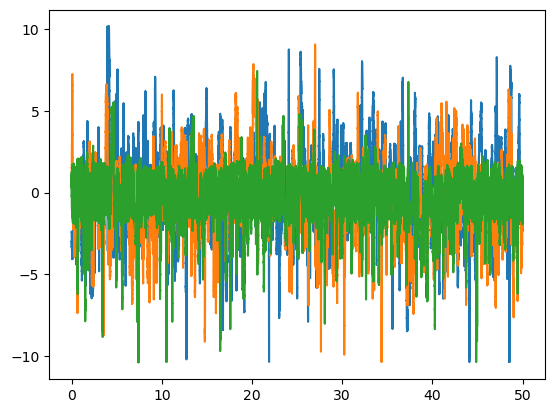

In [4]:
plt.plot(tt0, nn0[0])
plt.plot(tt1, nn1[0])
plt.plot(tt2, nn2[0])

In [11]:
# zdata = r"D:\others\20240625_forward_detection\20240625_z_lowpass1mhz\20240625_z_lowpass1mhz_04.mat"
# ydata = r"D:\others\20240625_forward_detection\20240625_x_lowpass1mhz\20240625_x_lowpass1mhz_03.mat"
# xdata = r"D:\others\20240625_forward_detection\20240625_y_lowpass1mhz\20240625_y_lowpass1mhz_04.mat"

# dtz, ttz, nnz = load_timestreams(zdata, channels=['C', 'D'])
# dty, tty, nny = load_timestreams(ydata, channels=['A', 'D'])
# dtx, ttx, nnx = load_timestreams(xdata, channels=['B', 'D'])

In [128]:
data_dir = r"D:\others"
prefix = r"20240625_forward_detection\20240625_z_lp1mhz_hp1khz"
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

dtz = 0
zz_list = []
for f in file_list:
    dtt, tt, zz = load_timestreams(f, ['D'])
    zz_list.append(zz[0])
    dtz = dtt
nnz = np.concatenate(zz_list)

In [123]:
data_dir = r"D:\others"
prefix = r"20240625_forward_detection\20240625_x_lp1mhz_hp50khz"
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

dtx = 0
xx_list = []
for f in file_list:
    dtt, tt, xx = load_timestreams(f, ['D'])
    xx_list.append(xx[0])
    dtx = dtt
nnx = np.concatenate(xx_list)

In [117]:
data_dir = r"D:\others"
prefix = r"20240625_forward_detection\20240625_y_lp1mhz_hp50khz"
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

dty = 0
yy_list = []
for f in file_list:
    dtt, tt, yy = load_timestreams(f, ['D'])
    yy_list.append(yy[0])
    dty = dtt
nny = np.concatenate(yy_list)

In [129]:
ffz, ppz= get_psd(dtz, None, nnz)
ffx, ppx= get_psd(dtx, None, nnx)
ffy, ppy= get_psd(dty, None, nny)

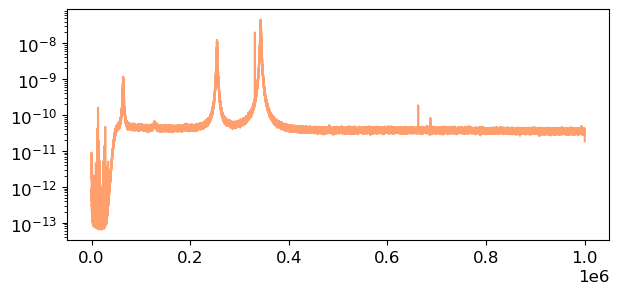

In [119]:
plt.plot(ffy, ppy)
plt.yscale('log')

Calibration factor square $c^2$: 1957620585778.964
Calibration factor square $c^2$: 1069136005413.0686
Calibration factor square $c^2$: 621423360689.8474


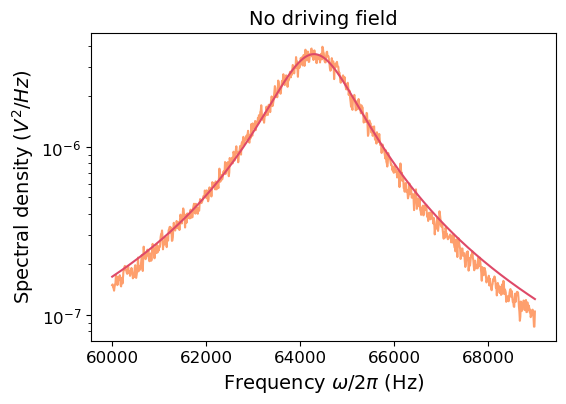

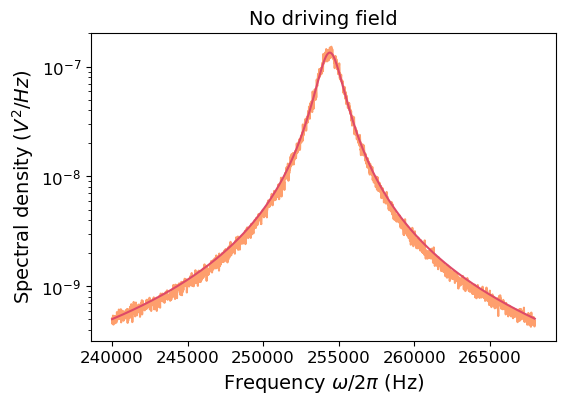

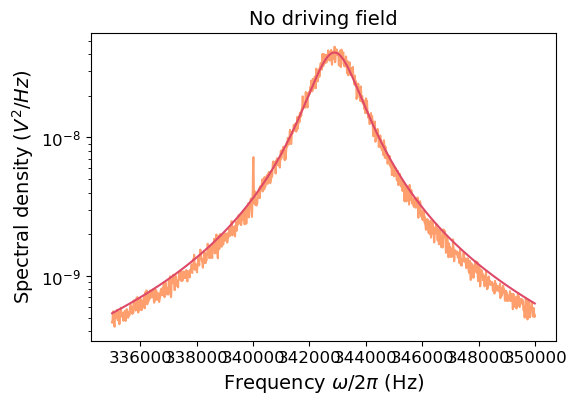

In [130]:
c_2_z = cal_peak(ffz, ppz, 6000, 6900, [5e7, 61000*2*np.pi, 8000])
c_2_x = cal_peak(ffx, ppx, 24000, 26800, p0=[5e7, 254000*2*np.pi, 8000])
c_2_y = cal_peak(ffy, ppy, 33500, 35000, [5e7, 342000*2*np.pi, 8000])

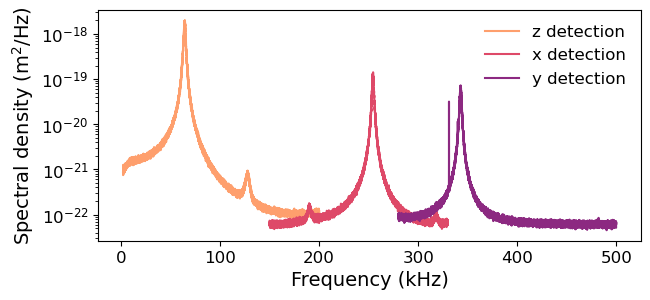

In [131]:
plt.plot(ffz[200:20000]/1000, ppz[200:20000]/c_2_z, label='z detection')
plt.plot(ffx[15000:33000]/1000, ppx[15000:33000]/c_2_x, label='x detection')
plt.plot(ffy[28000:50000]/1000, ppy[28000:50000]/c_2_y, label='y detection')

plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density (m$^2$/Hz)')
plt.legend(frameon=False)
plt.yscale('log')